# **AM 207**: Homework 7 Solutions

_ _ _ _ _

Verena Kaynig-Fittkau & Pavlos Protopapas <br>
Handed out: Thursday, March 26, 2015<br>
Due: 11.59 P.M. Wednesday, April 1, 2015<br>

**Instructions**:

+ Upload your answers in an ipython notebook to the dropbox.

+ Your individual submissions use the following filenames: AM207_YOURNAME_HM7.ipynb

+ Your code should be in code cells as part of your ipython notebook. Do not use a different language (or format) unless you get permission from the TFs. If you use any special libraries you must include them with your code (program should run as is). 

+ If you have multiple files (e.g. you've added code files and images) create a tarball for all files in a single file and name it: AM207_YOURNAME_HM7.tar or AM207_YOURNAME_HM7.zip

+ Please remember that your solution should be a report! We would like some explanations of your ideas, and ways to approach the solution. Also please comment your code.
_ _ _ _ _

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
from statsmodels.formula.api import ols
from scipy.stats import chi2

## Question 1 : Metropolis-Hastings sampler, slice sampler and HMC sampler

Consider

$$f(x,y)= \exp(-x^4-y^4+2xy-51x^2-51y^2+100\sqrt{x^2+y^2})$$

Sample $ f(x,y) $ by writing a

1. Metropolis or Metropolis-Hastings sampler

2. HMC sampler

3. Slice sampler (optional, extra credit)

For each sampler, show a 2D plot of the samples and a traceplot of samples for each marginal distribution. Describe convergence diagnostics for each sampling method, using a Geweke test and checking the autocorrelation. Use other diagnostic checks (e.g. histograms, Gelman-Rubin, ESS, etc...) that you think are appropriate and are comfortable working with. Discuss how your samplers performed, using the same burn-in and thinning parameters to ensure comparability.

## Solutions: 
### Contour plot
Let us first show the contour plot of the function. We plot the $f(x, y)$ in $[-2,2]^2$.

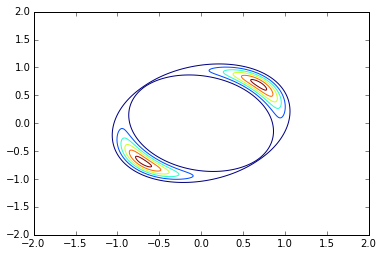

In [40]:
# define f(x,y) and log(f(x,y))
def f(x,y):
    return np.exp(-x**4-y**4+ 2.*x*y-51.*x**2-51.*y**2+100.*np.sqrt(x**2+y**2))
def logf(x,y):
    return -x**4-y**4+ 2.*x*y-51.*x**2-51.*y**2+100.*np.sqrt(x**2+y**2)
# plot the contour plot
x = np.linspace(-2,2,1000)
y = np.linspace(-2,2,1000)
x, y = np.meshgrid(x,y)
z = f(x,y)
plt.contour(x, y, z)
plt.show()

### Plots and analysis of functions

We will define some functions that we use repeatedly. Firstly, we define a function that shows the two dimensional histogram.

In [41]:
# plot the two dimension histogram of the results
def plot_2d_hist(x, y, title, plot_bins, plot_range):
    histo, xedge, yedge = np.histogram2d(x, y, bins = plot_bins, range = plot_range)
    histo = histo/histo.max()
    plt.imshow(histo.T,vmin=histo.min(),vmax=histo.max(), \
                extent=[xedge.min(),xedge.max(),yedge.min(),yedge.max()],origin='lower');
    plt.colorbar();
    plt.title(title);
    plt.xlabel('x');
    plt.ylabel('y');

Secondly, we define a function to show the trace plot of the sampler.

In [42]:
# show the trace plots of the chains
def plot_trace(x, y):
    plt.figure(figsize = (14,5))
    plt.subplot(121)
    plt.plot(x)
    plt.xlabel("run")
    plt.ylabel("x")
    plt.title("Trace plot of x")
    plt.subplot(122)
    plt.plot(y)
    plt.xlabel("run")
    plt.ylabel("y")
    plt.title("Trace plot of y")
    plt.show()

#### Geweke test
Now, we define a function to perform the Geweke test. As discussed in HW4, computing the exact Geweke test is very complicated, so we suggest using the built in Geweke test function in the package 'pymc'. We also define a function to plot the Geweke test plot of x and y.

In [43]:
# plot the Geweke tests of the results
import pymc as pm
def Geweke_plot_pymc(x, y, intervals):
    gewekex = pm.geweke(x, first=0.1, last=0.5, intervals = intervals)
    gewekey = pm.geweke(y, first=0.1, last=0.5, intervals = intervals)
    plt.figure(figsize=(14,5))
    pm.Matplot.geweke_plot(gewekex, 'x')
    plt.show()
    plt.figure(figsize=(14,5))
    pm.Matplot.geweke_plot(gewekey, 'y')
    plt.show()

#### Autocorrelation
Now, we define a function to get the autocorrelation of the chain.

In [44]:
from statsmodels.tsa.stattools import acf
# plot the autocorrelations of the chains
def plot_acf(x, y, lags):
    autox = acf(x, nlags = lags)
    autoy = acf(y, nlags = lags)
    plt.figure(figsize=(14,5))
    plt.subplot(121)
    plt.plot(autox)
    plt.xlabel("lag")
    plt.ylim((0,1))
    plt.title("Autocorrelation plot of x")
    plt.subplot(122)
    plt.plot(autoy)
    plt.ylim((0,1))
    plt.xlabel("lag")
    plt.title("Autocorrelation plot of y")
    plt.show()

#### Gelman-Rubin diagnostics
For the Gelman-Rubin diagnostics, we need to sample multiple chains to get the test statistics. For example, let $z_{i,j}, 1\leq i\leq m, 1\leq j\leq n$ be the $j$th sample from the $i$th chain. We have already deleted the burnin samples from each chain. The Gelman-Rubin statistics are defined as:

$$B=\frac{n}{m-1}\sum_{i=1}^m (\bar{z}_{i}-\bar{z})^2, \bar{z}_{i}=\frac{1}{n}\sum_{j=1}^n z_{i,j}, \bar{z}=\frac{1}{m}\sum_{i=1}^m \bar{z}_{i}$$

$$W=\frac{1}{m}\sum_{i=1}^m s_i^2, s_i^2=\frac{1}{n-1}\sum_{j=1}^n (z_{i,j}-\bar{z}_i)^2$$

$$\hat{\rm{var}}^{+}(z)=\frac{n-1}{n}W+\frac{1}{n}B$$

$$\hat{R} = \sqrt{\frac{\hat{\rm{var}}^{+}(z)}{W}}$$

$\hat{R}$ will decline to 1 as $n\to\infty$ if all the chains do not mix.

In [45]:
# compute Gelman-Rubin diagnostics
def Gelman_Rubin(Z, m, n):
    # Z is a matrix, and each row represents a chain.
    barzi = Z.mean(axis=1)
    barz = Z.mean()
    B = 1.*n/(m-1)*((barzi-barz)**2).sum()
    s = np.zeros(m)
    for i in xrange(m):
        s[i] = 1.0/(n-1)*((Z[i,:] - barzi[i])**2).sum()
    W = s.mean()
    varz = 1.0*(n-1)/n*W + 1.0/n*B
    R = np.sqrt(varz/W)
    return R

#### Effective sample size computing
Now, we show a method for computing effective sample size with multiple chains. The effective sample size is defined as:

$$\rm{n}_{\rm{eff}}=\frac{mn}{1+\sum_{t=1}^\infty \rho_t}$$

We estimate the autocorrelation $\rho_t$ by 

$$V_t = \frac{1}{m(n-t)}\sum_{i=1}^m\sum_{j=t+1}^n (z_{i,j}-z_{i,j-t})^2$$
$$\hat{\rho}_t=1-\frac{V_t}{\hat{\rm{var}}^{+}(z)}$$.

We compute a partial sum, starting from lag 0 and continuing until the sum of autocorrelation estimates for two succesive lags $\hat{\rho}_{2t'}+\hat{\rho}_{2t'+1}$ is negative. We use this positive partial sum as our estimate of $\sum_{t=1}^\infty \rho_t$
$$\hat{n}_{\rm{eff}} = \frac{mn}{1+\sum_{t=1}^T \hat{\rho}_t}$$

The function is found as follows:

In [46]:
def V(Z, t, m, n):
    Zdiff = Z[:, t:] - Z[:,:(n-t)]
    return 1.0/(m*(n-t))* (Zdiff**2).sum()
# Compute effective sample size
def ESS(Z, m, n):
    barzi = Z.mean(axis=1)
    barz = Z.mean()
    B = 1.*n/(m-1)*((barzi-barz)**2).sum()
    s = np.zeros(m)
    for i in xrange(m):
        s[i] = 1.0/(n-1)*((Z[i,:] - barzi[i])**2).sum()
    W = s.mean()
    varz = 1.0*(n-1)/n*W + 1.0/n*B
    rho = [1-V(Z, 1, m, n)/(2*varz)]
    rhosum = 0
    t = 1
    while rhosum >= 0:
        rho1 = 1-V(Z, 2*t, m, n)/(2*varz)
        rho2 = 1-V(Z, 2*t+1, m, n)/(2*varz)
        rho.append(rho1)
        rho.append(rho2)
        rhosum = rho1 + rho2
        t += 1
    return n/(1+2*sum(rho))

### Metropolis-Hasting sampler

In [47]:
# Metropolis-Hasting algorithm
def MH(x0, y0, logf, N, burnin, sigma):
    x = np.zeros(N)
    y = np.zeros(N)
    xold = x0
    yold = y0
    r = np.random.random(N)
    count = 0
    for i in xrange(N):
        xnew = np.random.normal(xold, sigma)
        ynew = np.random.normal(yold, sigma)
        
        if np.log(r[i]) < logf(xnew, ynew) - logf(xold, yold):
            xold = xnew
            yold = ynew
            count += 1
        x[i] = xold
        y[i] = yold
    
    print "The acceptance rate is "+ str(float(count)/N)+"."
    return x[burnin:], y[burnin:]

In [48]:
# Set sample size, burnin size and sigma
N = 100000
burnin = 20000
sigma = 0.2
x, y = MH(np.random.normal(1), np.random.normal(1),logf, N, burnin, sigma)

The acceptance rate is 0.46661.


Now, we show the two dimensional histogram of the sampling result. The histogram shows the results are good. We also plot the traceplot and autocorrelation plot with lags=500. The autocorrelations of the chains are high and do not decay very quickly. 

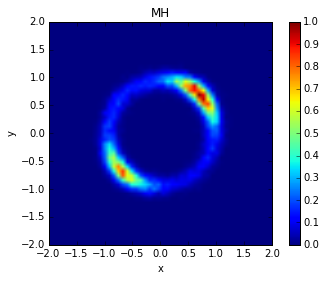

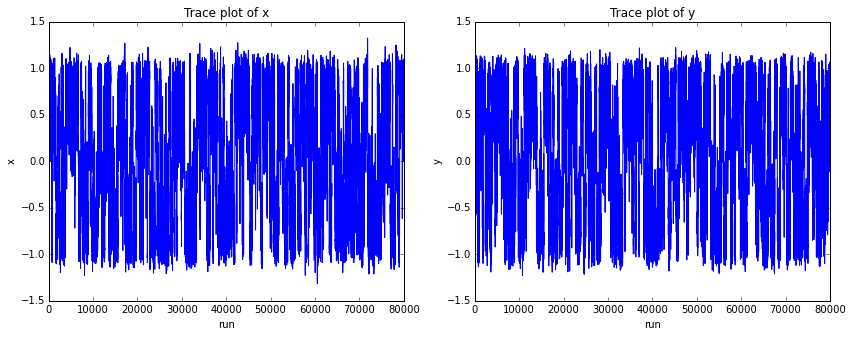

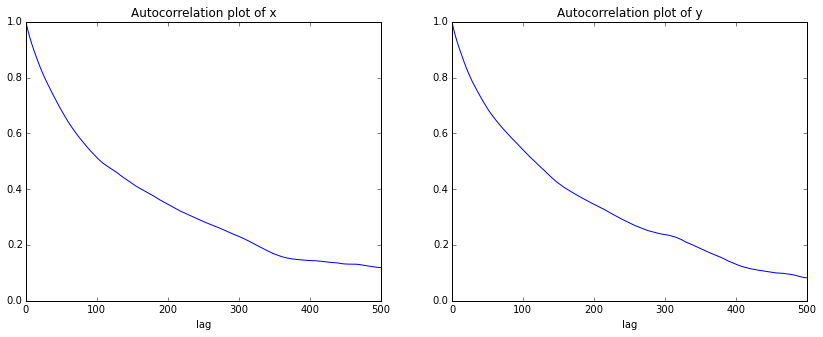

In [49]:
plot_2d_hist(x,y,"MH", 50, [[-2,2],[-2,2]])
plot_trace(x,y)
plot_acf(x, y, 500)

Now, we present the Geweke test for the chain. The results show that the chain has converged.

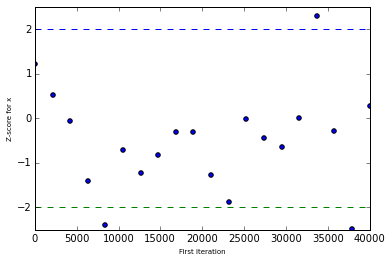

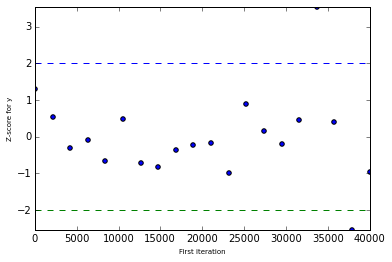

In [52]:
intervals = 20
Geweke_plot_pymc(x, y, intervals)

We run four chains and compute the Gelman-Rubin diagnostics and the effective sample size. The Gelman-Rubin diagnostics shows that the chains do not mix. The effective sample size is smaller than 200 when we sample 100,000 ponints. This effective sample size is too small, and we will use Hamiltonian Monte Carlo and slice sampler to improve performance.

In [53]:
m = 4
X = np.zeros((m, N-burnin))
Y = np.zeros((m, N-burnin))
for i in xrange(m):
    X[i,:], Y[i,:] = MH(np.random.normal(1), np.random.normal(1), logf, N, burnin, sigma)

The acceptance rate is 0.46862.
The acceptance rate is 0.46747.
The acceptance rate is 0.46651.
The acceptance rate is 0.46634.


In [54]:
print "The Gelman-Rubin diagnostics for x is "+ str(Gelman_Rubin(X, m, N-burnin)) +" and for y is "+ str(Gelman_Rubin(Y, m, N-burnin))+"."

The Gelman-Rubin diagnostics for x is 1.00115825451 and for y is 1.00174360741.


In [55]:
print "The effective sample size for x is "+ str(ESS(X, m, N-burnin)) + "and for y is " +str(ESS(Y, m, N-burnin))+"."

The effective sample size for x is 188.313124596and for y is 169.380858165.


### Hamiltonian Monte Carlo sampler

In [56]:
# Hamiltonian Monte Carlo sampler
def HMC(x0, y0, logf, dU1, dU2, N, M, e, L, burnin):
    x = np.zeros(N)
    y = np.zeros(N)
    q1old = x0
    q2old = y0
    r = np.random.random(N)
    count = 0
    
    for i in xrange(N):
        p1 = np.random.normal(1)*np.sqrt(M)
        p2 = np.random.normal(1)*np.sqrt(M)
        q1 = q1old
        q2 = q2old
        p1old = p1
        p2old = p2
        
        p1 -= 0.5*e*dU1(q1, q2)
        p2 -= 0.5*e*dU2(q1, q2)
        for j in xrange(L-1):
            q1 += e*p1/M
            q2 += e*p2/M
            p1 -= e*dU1(q1, q2)
            p2 -= e*dU2(q1, q2)
        q1 += e*p1/M
        q2 += e*p2/M
        p1 -= 0.5*e*dU1(q1, q2)
        p2 -= 0.5*e*dU2(q1, q2)
        
        q1new = q1
        q2new = q2
        p1new = -p1
        p2new = -p2
        
        if np.log(r[i]) < logf(q1new, q2new) - 0.5*(p1new**2+p2new**2)/M - logf(q1old, q2old) + 0.5*(p1old**2+p2old**2)/M:
            q1old = q1new
            q2old = q2new
            count += 1
        
        x[i] = q1old
        y[i] = q2old
    
    print "The acceptance rate is "+ str(float(count)/N)+"."
    return x[burnin:], y[burnin:]
        

In [57]:
# The derivative functions
dU1 = lambda x, y: 4.*x**3 - 2.*y +102.*x -100.*x/np.sqrt(x**2+y**2)
dU2 = lambda x, y: 4.*y**3 - 2.*x +102.*y -100.*y/np.sqrt(x**2+y**2)

In [58]:
# sample size, burnin size, M, epsilon and L
N = 100000
burnin = 20000
M = 0.5
e = 0.1
L = 10
x, y = HMC(np.random.normal(1), np.random.normal(1), logf, dU1, dU2, N, M, e, L, burnin)

The acceptance rate is 0.63933.


Now, we show the two dimensional histogram of the sampling result. The histogram shows the results are good. We also plot the traceplot and autocorrelation plot with lags=500. The autocorrelations of the chains are much lower than the Monte Carlo sampler and performance is better.

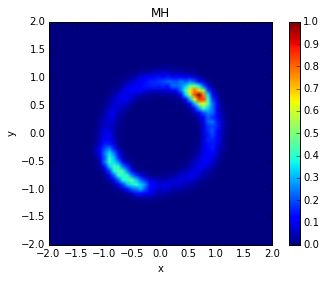

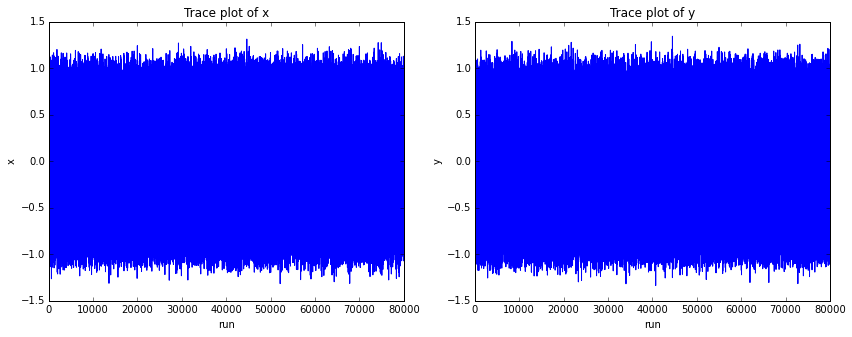

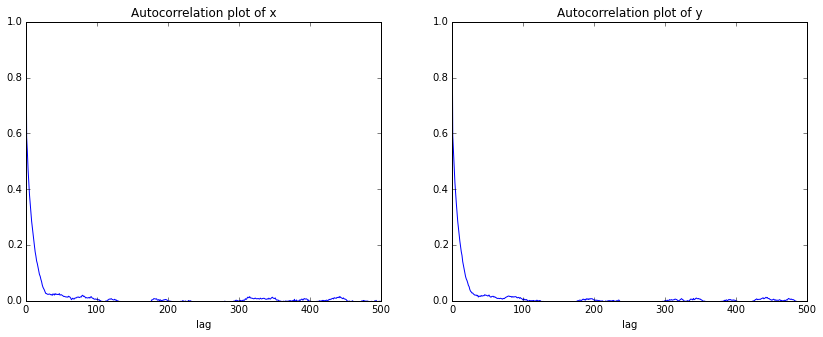

In [59]:
plot_2d_hist(x,y,"MH", 50, [[-2,2],[-2,2]])
plot_trace(x,y)
plot_acf(x, y, 500)

Now, we present the Geweke test for the chain. The results also show that the chain has converged.

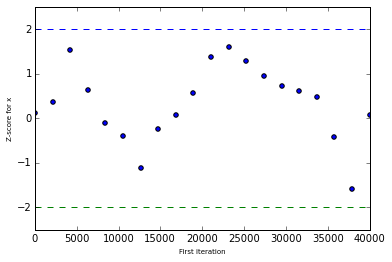

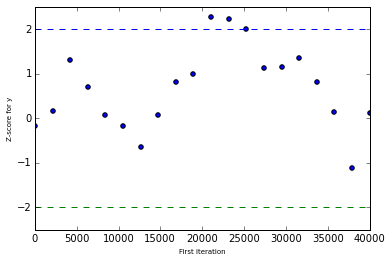

In [61]:
intervals = 20
Geweke_plot_pymc(x, y, intervals)

We run four chains and compute the Gelman-Rubin diagnostics and the effective sample size. The Gelman-Rubin diagnostics show that the chains do not mix. The effective sample size is around 6,000 when we sample 100,000 ponints. The effective sample size is now much larger than before, and the Hamiltonian Monte Carlo performs better than Monte Carlo.

In [62]:
m = 4
X = np.zeros((m, N-burnin))
Y = np.zeros((m, N-burnin))
for i in xrange(m):
    X[i,:], Y[i,:] = HMC(np.random.normal(1), np.random.normal(1), logf, dU1, dU2, N, M, e, L, burnin)

The acceptance rate is 0.64055.
The acceptance rate is 0.6407.
The acceptance rate is 0.63943.
The acceptance rate is 0.63867.


In [63]:
print "The Gelman-Rubin diagnostics for x is "+ str(Gelman_Rubin(X, m, N-burnin)) +" and for y is "+ str(Gelman_Rubin(Y, m, N-burnin))+"."

The Gelman-Rubin diagnostics for x is 1.00009623286 and for y is 1.00009845101.


In [64]:
print "The effective sample size for x is "+ str(ESS(X, m, N-burnin)) + "and for y is " +str(ESS(Y, m, N-burnin))+"."

The effective sample size for x is 6091.38301889and for y is 6104.76677059.


### Slice sampler

For slice sampler, if we are at $z_0$, we sample $t\sim U(0, f(z_0))$ and then sample $z*$ uniformly from $\{z:f(z)>t\}$. In fact, it's very difficult to sample from $\{z:f(z)>t\}$ so we choose a rejection sampling method here. If we would like to sample uniformly from $\{x,y:f(x,y)>t\}$, by simple calculation, we will have 

$$|x|,|y|<(-\log(t)+50)^{0.25}$$
So we could sample $x,y$ from $U[-(-\log(t)+50)^{0.25},(-\log(t)+50)^{0.25}]^2$ and accept points until we have $f(x, y)>t$.

In [63]:
# slice sampler
def slice(x0, y0, N, f):
    x = np.zeros(N)
    y = np.zeros(N)
    
    xold = x0
    yold = y0
    count = 0 
    for i in xrange(N):
        t = np.random.random(1)*f(xold, yold)
        bound = (-np.log(t)+50)**0.25
        acc = 0
        while acc == 0:
            xnew = np.random.random(1)*2*bound - bound
            ynew = np.random.random(1)*2*bound - bound
            count += 1
            if f(xnew, ynew) > t:
                acc = 1
        xold = xnew
        yold = ynew
        x[i] = xold
        y[i] = yold
    # print the ratio of points that are used for the final results.
    print "The acceptance rate is :" +str(float(N)/count)+"."
    return x, y

In [70]:
# sample size
N = 10000
x, y = slice(np.random.normal(1), np.random.normal(1), N, f)

The acceptance rate is :0.121251803621.


In fact, we will choose roughly one point in ten from the sampler. This is because of the shape of the function. We are sampling from a square, while the inner part of the histogram shows that the density is very low. We could improve performance if we could find better sampler. We will look at the trace plot and autocorrelation plot. We can see that there is very small autocorrelation in the chains. This is because that the samples do not come from Markov Chain, so the autocorrelation is very low. We also perform the Geweke test which shows ... For Gelman-Rubin diagnostics, we find the chains do not mix. The effective sample size is close to the real sample size.

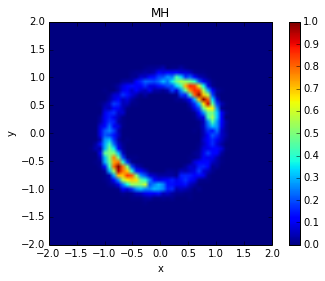

In [77]:
plot_2d_hist(x,y,"MH", 50, [[-2,2],[-2,2]])

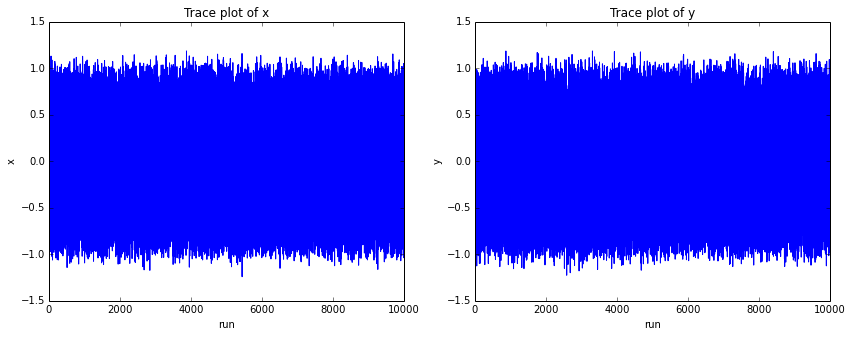

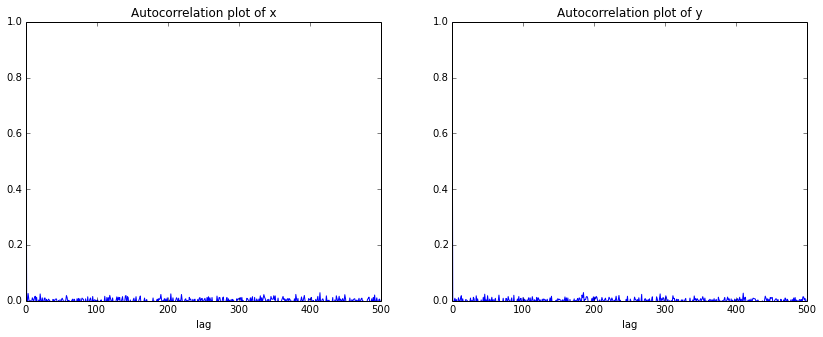

In [78]:
plot_trace(x,y)
plot_acf(x, y, 500)

In [72]:
intervals = 20
#Geweke_plot_pymc(x, y, intervals)

In [73]:
m = 4
X = np.zeros((m, N))
Y = np.zeros((m, N))
for i in xrange(m):
    X[i,:], Y[i,:] = slice(np.random.normal(1), np.random.normal(1), N, f)

The acceptance rate is :0.127730233746.
The acceptance rate is :0.117521241964.
The acceptance rate is :0.122080744204.
The acceptance rate is :0.130614803882.


In [74]:
print "The Gelman-Rubin diagnostics for x is "+ str(Gelman_Rubin(X, m, N-burnin)) +" and for y is "+ str(Gelman_Rubin(Y, m, N-burnin))+"."

The Gelman-Rubin diagnostics for x is 1.00003698496 and for y is 1.00003602708.


In [76]:
print "The effective sample size for x is "+ str(ESS(X, m, N)) + "and for y is " +str(ESS(Y, m, N))+"."

The effective sample size for x is 9711.2233964and for y is 9855.89208454.


### Summary of the three samplers

Metropolis-Hasting sampler is a simple and straightforward method. However, the performance is not very good when the function has a strange shape. The Hamiltonian Monte Carlo sampler can outperform the Metropolis-Hasting sampler and  adjust the step size based on the function. In fact, both of the methods need tuned parameters ($\sigma$, $\epsilon$, L, M). We could tune the parameters by controlling the acceptance rate and autocorrelation. We introduce some methods for analyzing the convergence of the algorithms, i.e. Geweke test, Gelman-Rubin diagnostics and effective sample size. The results show that HMC is better than MH in this particular problem. The difficulty with HMC is that we need to compute the derivatives and sampling can take a long time.

Slice sampler could result in almost perfect samples, but it is difficult to sample from the slice. In this problem, we found some point bounds and could use rejection sampling. But rejection sampling might not be very efficient when the function is difficult.

## Question 2 : Model Mis-specification and Sensitivity of Priors

Verena is curious about the relationship between the amount of chalk she uses during the lectures and the "smudge score" of her clothes. The "smudge score" is a real number:  the bigger the number, the dirtier her clothes are. She did some experiments and recorded the results in "chalk.csv". Column "x" is the amount of chalk used in the lecture, and column "y" is the smudge score of her clothes. We will model x and y by a linear regression model.

\begin{equation}
y_i = \beta_0 + x_i \beta + \sigma\epsilon_i,\ i=1,\ldots, n. \ \epsilon_i\mbox{ is a iid random noise.}
\end{equation}

First, we solve the problem from a frequentist perspective using linear regression.

**Part 1: Linear regression analysis**

1. Plot the raw data, and check for outliers.
2. Give the least squares estimate of parameters $\beta_0$, $\beta$ and $\sigma$ and their respective 95% confidence intervals. (Please use the functions from package **statsmodels.formula.api.ols**, which was already loaded above.)
3. Are the estimations of $\beta_0$, $\beta$, $\sigma^2$ valid? For which variable is the estimation biased, and what is the reason for this?

Next, we use the Bayesian method of estimating the parameters in the regression model, and consider two kinds of priors. 

**Prior 1 (Flat priors)** 

$$p(\beta_0,\beta,\sigma^2)\propto 1/\sigma^2.$$

**Prior 2 ('Conjugate' priors)** 

$$\beta_0\sim\mathcal{N}(0.0, 0.5^2),\beta\sim\mathcal{N}(0.0, 0.5^2),\sigma^2\sim Inv-\chi^2(\nu, s^2).$$

The prior for $\sigma^2$ is the scaled inverse chi-squared distribution with $\nu=2.0$ degrees of freedom and a scaling factor of $s^2=1.0$. 

**Part 2.** Assume that we model $\epsilon_i\sim N(0,1)$. 

1. Write an M-H algorithm to obtain posterior samples of $\beta_0$, $\beta$ and $\sigma^2$. Please report the posterior means and parameter variances.
2. Obtain the $95\%$ predictive interval of $y_i$ for each $x_i$. How many of the observed $y_i$s are inside this interval?
3. Do the results from the two different priors differ? Describe what you found.

**Part 3.** Now we model $\epsilon_i\sim t_2$, that is a t distribution with degree of freedom 2. 

1. Write an M-H algorithm to obtain posterior samples of $\beta_0$, $\beta$ and $\sigma^2$. Please report the posterior means and parameter variances.
2. Obtain the $95\%$ predictive interval of $y_i$ for each $x_i$. How many of the observed $y_i$s are inside this interval?
3. Do the results from the two different priors differ? Describe what you found.

**Part 4. ** General comparison

1. Compare your results from Parts 1, 2 and 3. Which one yields the most valid result?  (i.e., we could compare the posterior means and variances of all the methods.) What is the reason for this?
2. Plot the raw data and the predictive intervals from Part 2 and Part 3 together in the same plot. Compare the four predictive intervals. Which one do you think performs best, and what is the reason for this? 

## Hint for likelihood functions
Define $\bar{X} = \frac{\sum_{i=1}^n x_i}{n}$, $\bar{Y} = \frac{\sum_{i=1}^n y_i}{n}$, $S_{X}^2 =\frac{\sum_{i=1}^n x_i^2}{n}$, $S_Y^2=\frac{\sum_{i=1}^n y_i^2}{n}$, $S_{XY} = \frac{\sum_{i=1}^n x_i y_i}{n}$. 

** normal noise**

If we assume $\epsilon_i$ are i.i.d. Gaussian instead of i.i.d. t, the likelihood function is given by

$$p(y_1,\ldots, y_n|\beta_0,\beta,\sigma^2)\propto \frac{1}{\sigma^n}\exp(-\frac{\sum_{i=1}^n (y_i-\beta_0-\beta x_i)^2}{2\sigma^2}),$$

which can be simplified as

$$p(y_1,\ldots, y_n|\beta_0,\beta,\sigma^2)\propto \frac{1}{\sigma^{n}}\exp(-\frac{n (\beta_0^2 + \beta^2 S_{X}^2 + 2\beta_0\beta \bar{X} - 2\beta_0 \bar{Y} - 2\beta S_{XY}+S_Y^2)}{2\sigma^2}).$$

** t distribution noise**

If we assume $\epsilon_i$ are i.i.d. t distribution with degree of freedom $\nu$, the likelihood function is given by

$$p(y_1,\ldots, y_n|\beta_0,\beta,\sigma^2)\propto \frac{1}{\sigma^n}\prod_{i=1}^n (1+\frac{(y_i-\beta_0-x_i\beta_1)^2}{\sigma^2\nu})^{-\frac{\nu+1}{2}}.$$

## Solutions:

### Part 1

Firstly, we load the data and show the scatter plot. There is at least one outlier of the data.

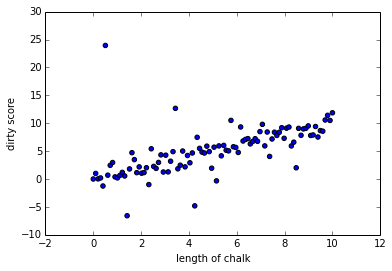

In [11]:
data = pd.read_csv("chalk.csv").values[:,1:3]
x = data[:,0]
y = data[:,1]
data = pd.DataFrame({'x':x,'y':y})
plt.scatter(x,y)
plt.xlabel("length of chalk")
plt.ylabel("smudge score")
plt.show()

Now, we perform the least square analysis of x and y. We could have $\hat{\beta_0} = 0.7770$ and $\hat{\beta}=0.8712$. The $95\%$ confidence interval of $\beta_0$ is $[-0.496, 2.050]$. The $95\%$ confidence interval for $\beta$ is $[0.651, 1.091]$. The estimate of $\sigma^2$ is 10.23. The confidence interval of $\sigma^2$ is [8.04, 14.12]. The estimate of $\sigma$ is 3.20. The confidence interval of $\sigma$ is [2.83,3.76].

In [13]:
model = ols("y ~ x", data).fit()
print "The estimate of sigma^2 is "+str((model.resid**2).mean())+"."
print "The estimate of sigma is "+str(np.sqrt((model.resid**2).mean()))+"."
interval = [(model.resid**2).sum()/chi2.ppf(0.975, 98),(model.resid**2).sum()/chi2.ppf(0.025, 98)]
print "The confidence interval of sigma^2 is ["+str(interval[0])+", "+str(interval[1])+"]."
print "The confidence interval of sigma is ["+str(np.sqrt(interval[0]))+", "+str(np.sqrt(interval[1]))+"]."
print(model.summary()) 

The estimate of sigma^2 is 10.2375842266.
The estimate of sigma is 3.19962251314.
The confidence interval of sigma^2 is [8.04322559843, 14.1206228465].
The confidence interval of sigma is [2.83605810914, 3.75774172163].
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     61.77
Date:                Fri, 03 Apr 2015   Prob (F-statistic):           5.05e-12
Time:                        13:22:15   Log-Likelihood:                -258.20
No. Observations:                 100   AIC:                             520.4
Df Residuals:                      98   BIC:                             525.6
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Co

We plot the result on top of the raw data. The results look nice and the line captures the trend of the data. Estimates of $\beta_0$ and $\beta_1$ are valid and unbiased. However, due to the outliers, the estimate of $\sigma^2$ should be far larger than the real value and the estimate is not valid and unbiased. 

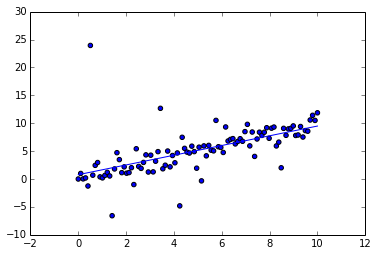

In [93]:
plt.scatter(x,y)
plt.plot(x, model.params[0]+model.params[1]*x)
plt.show()

### Part 2 & 3

Now, we study the performance of the posterior distribution with different prior distributions. 

In [114]:
# log posterior distribution of beta0, beta and sigma^2
def logprior(b0, b1, sigma2, opt1):
    if opt1 == "flat":
        return -np.log(sigma2)
    if opt1 == "conjugate":
        return - b0**2*2 - b1**2*2 - 2.0*np.log(sigma2) - 0.5/sigma2

def loglikelihood(b0, b1, sigma2, x, y, opt2):
    n = len(x)
    if opt2 == "gaussian":
        return -0.5*n*np.log(sigma2) - 0.5*((y-b0-b1*x)**2).sum()/sigma2
    if opt2 == "t":
        return -0.5*n*np.log(sigma2) - 1.5*(np.log(1+0.5*(y-b0-b1*x)**2/sigma2)).sum()
    
def logpost(b0, b1, sigma2, x, y, opt1, opt2):
    return logprior(b0, b1, sigma2, opt1) + loglikelihood(b0, b1, sigma2, x, y, opt2)

In [116]:
# mcmc algorithm
def mcmc(b0, b1, sigma2, x, y, opt1, opt2, N, burnin, e1, e2, e3):
    B0 = np.zeros(N)
    B1 = np.zeros(N)
    Sigma2 = np.zeros(N)
    
    b0old = b0
    b1old = b1
    sigma2old = sigma2
    count = 0
    r = np.random.random(N)
    for i in xrange(N):
        b0new = np.random.normal(b0old, e1)
        b1new = np.random.normal(b1old, e2)
        sigma2new = abs(np.random.normal(sigma2old, e3))
        p = logpost(b0new, b1new, sigma2new, x, y, opt1, opt2) - logpost(b0old, b1old, sigma2old, x, y, opt1, opt2)
        if np.log(r[i]) < p:
            b0old = b0new
            b1old = b1new
            sigma2old = sigma2new
            count += 1
                           
        B0[i] = b0old
        B1[i] = b1old
        Sigma2[i] = sigma2old
    print "The acceptance rate is "+ str(float(count)/N)+"."
    return np.vstack((B0[burnin:], B1[burnin:],Sigma2[burnin:]))

We write some functions that analyze the posterior mean and variance of the parameters. We could also plot the autocorrelation and histogram of the parameters.

In [141]:
# show posterior mean and variance
def post_ana(res):
    mean = res.mean(axis = 1)
    sd = np.zeros(3)
    sd[0] = np.std(res[0,:])
    sd[1] = np.std(res[1,:])
    sd[2] = np.std(res[2,:])
    print "The posterior mean and standard deviation for beta0 are "+str(mean[0])+" and "+str(sd[0])+"."
    print "The posterior mean and standard deviation for beta are "+str(mean[1])+" and "+str(sd[1])+"."
    print "The posterior mean and standard deviation for sigma2 are "+str(mean[2])+" and "+str(sd[2])+"."

In [142]:
# autocorrelaiton plot
def plot_acf_lm(res, lags):
    autob0 = acf(res[0,:], nlags = lags)
    autob1 = acf(res[1,:], nlags = lags)
    autosigma2 = acf(res[2,:], nlags = lags)
    plt.figure(figsize=(15,4))
    plt.subplot(131)
    plt.plot(autob0)
    plt.xlabel("lag")
    plt.ylim((0,1))
    plt.title("Autocorrelation plot of beta0")
    plt.subplot(132)
    plt.plot(autob1)
    plt.ylim((0,1))
    plt.xlabel("lag")
    plt.title("Autocorrelation plot of beta")
    plt.subplot(133)
    plt.plot(autosigma2)
    plt.ylim((0,1))
    plt.xlabel("lag")
    plt.title("Autocorrelation plot of sigma2")
    plt.show()

In [143]:
# posterior histogram
def plot_hist(res):
    plt.figure(figsize=(15,4))
    plt.subplot(131)
    plt.hist(res[0,:])
    plt.title("Histogram of beta0")
    plt.subplot(132)
    plt.hist(res[1,:])
    plt.title("Histogram of beta")
    plt.subplot(133)
    plt.hist(res[2,:])
    plt.title("Histogram of sigma2")

In [120]:
# compute the predictive intervals at each x 
def predict(res, x, y, m, opt2):
    n = len(x)
    x = x.reshape((n,1))
    count = 0
    Result = np.zeros((n, res.shape[1]*m))
    if opt2 == "gaussian":
        for i in xrange(res.shape[1]):
            Result[:,(i*m):(i*m+m)] = np.random.normal(scale = res[2,i], size=m*n).reshape((n,m)) + np.repeat(res[0,i]+res[1,i]*x,m, axis=1)
    if opt2 == "t":
        for i in xrange(res.shape[1]):
            Result[:,(i*m):(i*m+m)] = np.random.standard_t(df=2, size=m*n).reshape((n,m))*res[2,i] + np.repeat(res[0,i]+res[1,i]*x,m, axis=1)
    bounds = np.zeros((n,2))
    for i in xrange(n):
        bounds[i,:] = np.percentile(Result[i,:], [2.5,97.5])
        if y[i] < bounds[i,1] and y[i] > bounds[i,0]:
            count += 1
    print "There are "+str(count) +" yis out of "+str(n) +" that falls in the predictive interval."
    return bounds

From linear regression results, we choose our starting point as $(\beta_0,\beta_1,\sigma^2) = (0.8,0.8,1)$. Here, we don't choose $\sigma^2$ as the one from the linear regression because it would be far from the real case. The results of the two models with the two different priors are as follows.

In [121]:
b0 = 0.8
b1 = 0.8
sigma2 = 1
N = 20000
burnin = 5000
m = 100

#### Normal model
First, we analysis the Gaussian model with the flat prior. We see the autocorrelation for $\sigma^2$ is still high after 500 lags. The variance of $\sigma^2$ is very high.

In [123]:
e1, e2, e3 = 0.15, 0.15, 0.25
res_gaussian_flat = mcmc(b0, b1, sigma2, x, y, "flat", "gaussian", N, burnin, e1, e2, e3)
bounds_gaussian_flat = predict(res_gaussian_flat, x, y, m, "gaussian") 
post_ana(res_gaussian_flat)

The acceptance rate is 0.3959.
There are 99 yis out of 100 that falls in the predictive interval.
The posterior mean and standard deviation for beta0 are 0.984799409006 and 0.579535267311.
The posterior mean and standard deviation for beta1 are 0.840842483442 and 0.102488748277.
The posterior mean and standard deviation for sigma2 are 10.3319068439 and 1.40658573552.


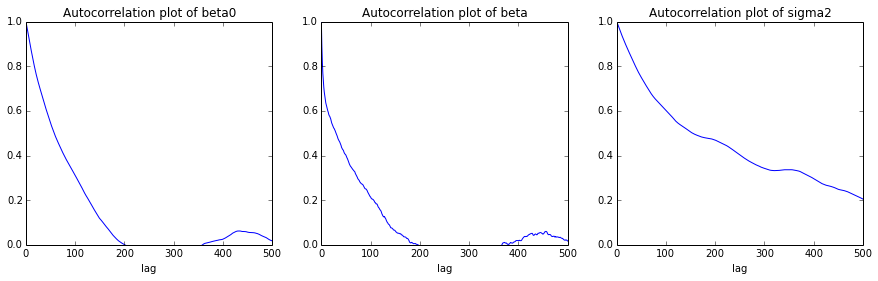

In [144]:
plot_acf_lm(res_gaussian_flat, 500)

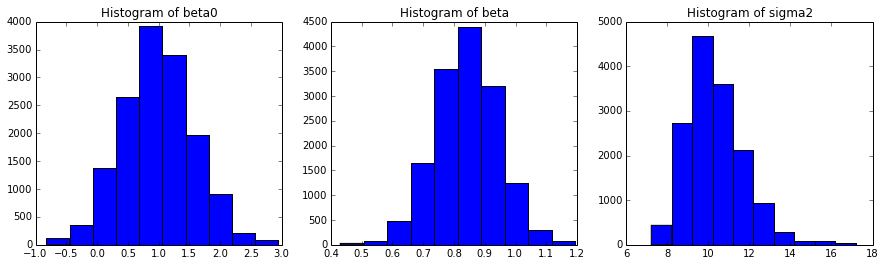

In [145]:
plot_hist(res_gaussian_flat)

Now, we analyze the Gaussian model with the 'conjugate' prior.  We see the autocorrelation for $\sigma^2$ is still high after 500 lags. The variance of $\sigma^2$ is very high.

In [126]:
res_gaussian_conjugate = mcmc(b0, b1, sigma2, x, y, "conjugate", "gaussian", N, burnin, e1, e2, e3)
bounds_gaussian_conjugate = predict(res_gaussian_conjugate, x, y, m, "gaussian") 
post_ana(res_gaussian_conjugate)

The acceptance rate is 0.37215.
There are 99 yis out of 100 that falls in the predictive interval.
The posterior mean and standard deviation for beta0 are 0.390842249104 and 0.384407067584.
The posterior mean and standard deviation for beta1 are 0.917869908243 and 0.0778925252366.
The posterior mean and standard deviation for sigma2 are 10.215922429 and 1.43941313769.


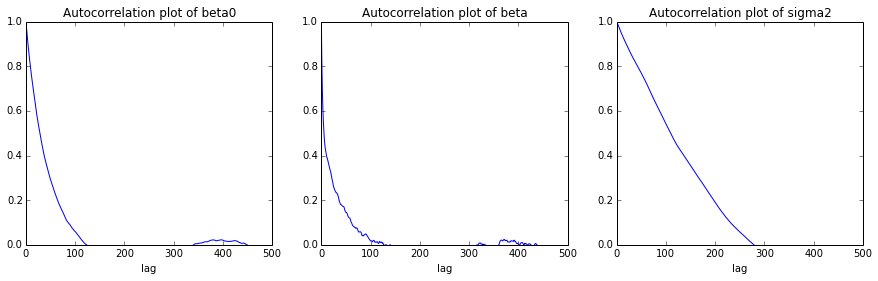

In [146]:
plot_acf_lm(res_gaussian_conjugate, 500)

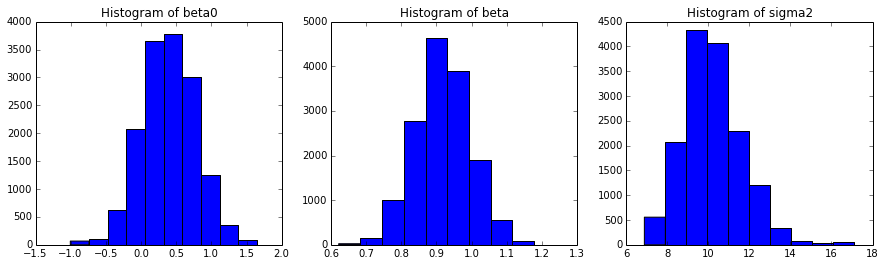

In [147]:
plot_hist(res_gaussian_conjugate)

In fact, the two models do not show much difference. The estimates of $\beta_0$ and $\beta$ are accurate while the estimate of $\sigma^2$ is very large. Most of the points fall in the predictive intervals. We plot them as follows. The predictive intervals are too wide for us to make accurate predictions.

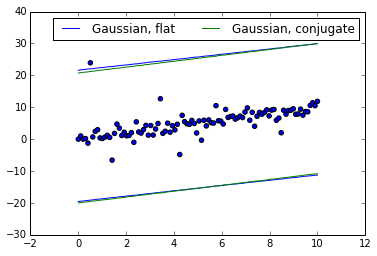

In [130]:
plt.scatter(x,y)
plt.plot(x, bounds_gaussian_flat[:,0], label="Gaussian, flat", color="blue")
plt.plot(x, bounds_gaussian_flat[:,1], color="blue")
plt.plot(x, bounds_gaussian_conjugate[:,0], label="Gaussian, conjugate", color="green")
plt.plot(x, bounds_gaussian_conjugate[:,1],  color="green")
plt.legend(ncol =2)
plt.show()

#### t distribution model
Now we analyze the t distribution model with the flat prior. The autocorrelation is now very low, and the variance for $\sigma^2$ is much smaller than the normal distribution model.

In [132]:
e1, e2, e3 = 0.1, 0.1, 0.1
res_t_flat = mcmc(b0, b1, sigma2, x, y, "flat", "t", N, burnin, e1, e2, e3)
bounds_t_flat = predict(res_t_flat, x, y, m, "t") 
post_ana(res_t_flat)

The acceptance rate is 0.2591.
There are 94 yis out of 100 that falls in the predictive interval.
The posterior mean and standard deviation for beta0 are -0.0593764319515 and 0.302455357546.
The posterior mean and standard deviation for beta1 are 1.02347011662 and 0.0518182448031.
The posterior mean and standard deviation for sigma2 are 1.20600773427 and 0.324566039135.


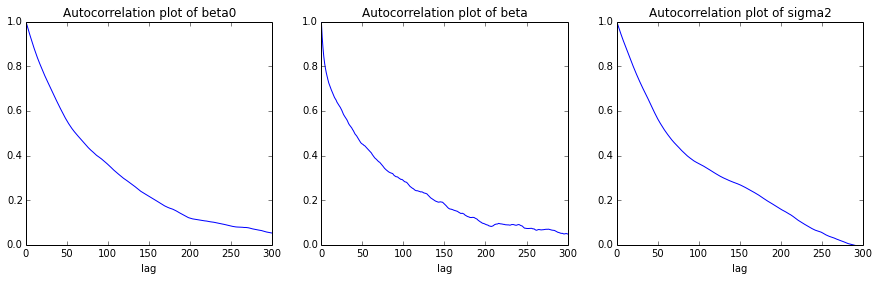

In [148]:
plot_acf_lm(res_t_flat, 300)

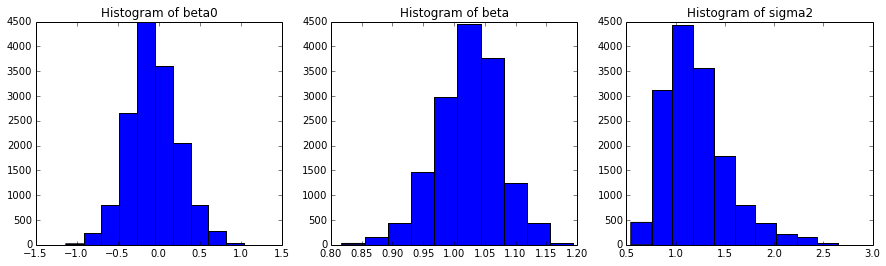

In [149]:
plot_hist(res_t_flat)

Finally, we analyze the t distribution model with the conjugate prior. The autocorrelation is now very low and the variance for $\sigma^2$ is much smaller than a normal distribution.

In [135]:
res_t_conjugate = mcmc(b0, b1, sigma2, x, y, "conjugate", "t", N, burnin, e1, e2, e3)
bounds_t_conjugate = predict(res_t_conjugate, x, y, m, "t") 
post_ana(res_t_conjugate)

The acceptance rate is 0.25535.
There are 94 yis out of 100 that falls in the predictive interval.
The posterior mean and standard deviation for beta0 are -0.0392358230375 and 0.235635747297.
The posterior mean and standard deviation for beta1 are 1.01791725866 and 0.0433725601714.
The posterior mean and standard deviation for sigma2 are 1.15240662388 and 0.238926030081.


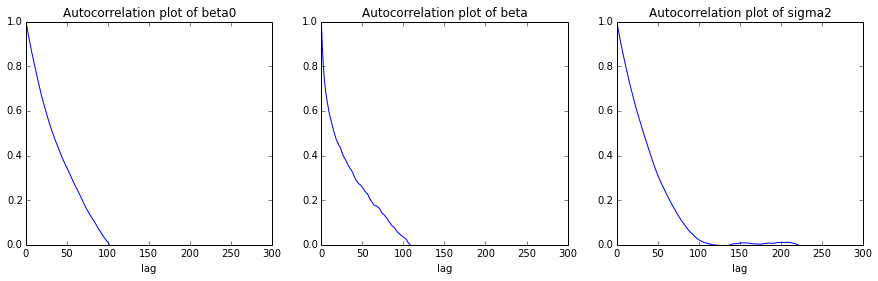

In [150]:
plot_acf_lm(res_t_conjugate, 300)

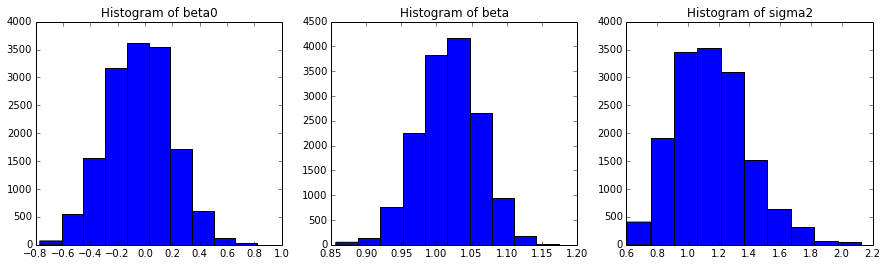

In [151]:
plot_hist(res_t_conjugate)

In fact, the two models do not show much difference. The estimates of $\beta_0$ ,$\beta_1$ and $\sigma^2$ are accurate. 94 of the points fall in the predictive intervals. We will plot the points as follows. The predictive intervals are now narrower than the normal distribution model, and we can make more accurate predictions.

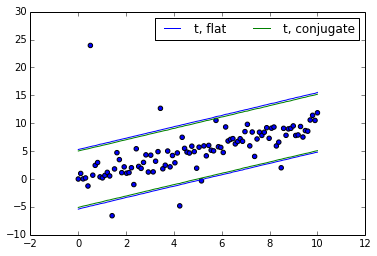

In [138]:
plt.scatter(x,y)
plt.plot(x, bounds_t_flat[:,0], label="t, flat", color="blue")
plt.plot(x, bounds_t_flat[:,1], color="blue")
plt.plot(x, bounds_t_conjugate[:,0], label="t, conjugate", color="green")
plt.plot(x, bounds_t_conjugate[:,1],  color="green")
plt.legend(ncol =2)
plt.show()

#### Part 4
We think that the model that has t distribution and the conjugate prior perform best. In fact, the means of $\beta_0$ and $\beta$ are different for different models. This comes from the outliers. The ordinary least square, we also assume that the errors come from a normal distribution. The normal distribution do not allow outliers while the t distribution with small degree of freedom could allow some outliers. We plot the probability density function of a standard normal distributio and a t distribution with a degree of freedom as 2. We could see that t distribution has a fatter tail than normal distribution.

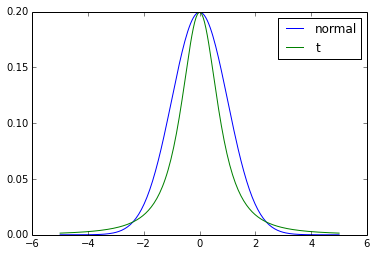

In [139]:
x0 = np.linspace(-5,5, 200)
y1 = 0.5*np.exp(-x0**2*0.5)/np.sqrt(2*np.pi)
y2 = 0.5/np.sqrt(2*np.pi)*(1+x0**2)**(-1.5)
plt.plot(x0,y1,label="normal")
plt.plot(x0,y2,label="t")
plt.legend()
plt.show()

Now, we plot the four predictive intervals by the four methods. We could see that normal distribution models have bigger intervals than the t distribution models. Bigger predictive intervals means that we could not get enough information from the analysis. In this case, the t distribution fits the data better than the normal distribution.

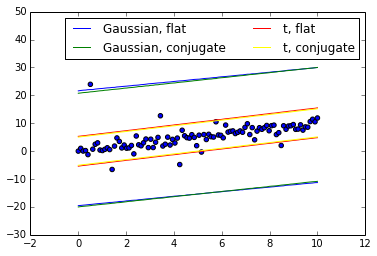

In [140]:
plt.scatter(x,y)
plt.plot(x, bounds_gaussian_flat[:,0], label="Gaussian, flat", color="blue")
plt.plot(x, bounds_gaussian_flat[:,1], color="blue")
plt.plot(x, bounds_gaussian_conjugate[:,0], label="Gaussian, conjugate", color="green")
plt.plot(x, bounds_gaussian_conjugate[:,1],  color="green")
plt.plot(x, bounds_t_flat[:,0], label="t, flat", color="red")
plt.plot(x, bounds_t_flat[:,1], color="red")
plt.plot(x, bounds_t_conjugate[:,0], label="t, conjugate", color="yellow")
plt.plot(x, bounds_t_conjugate[:,1],  color="yellow")
plt.ylim((-30,50))
plt.legend(ncol =2)
plt.show()